# embedding-models

embedding models embed the text into numeric representations of many dimensions and can be trained to serve a lot of purposes like sentiment classification, semantic understanding

[Alt text](contrastive_learning.png)

In [1]:
#function to generate images with path specification required
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def imggen(im_path):
    img=mpimg.imread(im_path)
    plt.axis("off")
    return plt.imshow(img)

In [ ]:
imggen('contrastive_learning.png')

## contrastive learning
In order to accurately capture the semantic nature of a document, it often needs to be contrasted with another
document for a model to learn what makes it different or similar. 


so basically feeding the model with similar and dissimilar pairs..

like instead of a question why P? we model it with contrast as why P and not Q? this makes it learn more info about the subject and 
ability to learn different features that make the subject unique.

### the best way to apply contrastive learning is through sentence- transformers



# SBERT
### (or sentence-BERT)
1 LIMITATION OF BERT WAS the computational overhead because it uses a cross encoder and outputs 512*768 vector for a single sentence before similarity, either we use the [CLS] token that has a summary of the entire token embeddings but we still run a lot of compute in making those embeddings.

We can also use Glove= global vectors for word representation; It’s not a neural network like BERT. It’s a matrix factorization method trained on global word co-occurrence statistics from a giant corpus.

### sentence transformers:

uses 2 bert models parallely with tied weights, removes the classification head and brings in mean pooling over the token embeddings, to generate a final fixed size vector embedding which can later be used for similarity searches, compute is saved as we dont need to calculate with each sentence but only the ones in our query

also, we concat the sentences embedded along with the difference in the embeddings

In [ ]:
imggen("sentra.png")

### creating an embedding model 

to create an embedding model we first need some contrastual data for training

NLI natural language for inference provides various types of data for evaluation, one of them being mnli, that has premise and hypothesis pairs along with labels for contradiction, entailment or neutral relations

In [ ]:
imggen("mnli.png")

In [ ]:
#load dataset nli dataset
from datasets import load_dataset

train_dataset= load_dataset("glue","mnli", split='train').select(range(50_000))
train_dataset= train_dataset.remove_columns("idx")


In [ ]:
train_dataset = train_dataset.select_columns(['hypothesis', 'premise', 'label'])


### Fixing TensorFlow Registry Error

If you encounter the error "Name tf.RaggedTensorSpec has already been registered", restart the kernel before running the model training cells. This error occurs due to TensorFlow being imported multiple times.

In [ ]:
# Clear TensorFlow registry and restart imports
import sys
import importlib

# Remove tensorflow modules if already imported
modules_to_remove = [module for module in sys.modules.keys() if 'tensorflow' in module or 'keras' in module]
for module in modules_to_remove:
    del sys.modules[module]

# Clear GPU memory if using GPU
try:
    import tensorflow as tf
    tf.keras.backend.clear_session()
    if tf.config.list_physical_devices('GPU'):
        tf.config.experimental.reset_memory_growth(tf.config.list_physical_devices('GPU')[0])
except:
    pass

print("TensorFlow modules cleared. Ready for clean import.")

In [ ]:
train_dataset[:1]

In [ ]:
# Model training with proper type handling
import numpy as np
import os

# Set environment variables to avoid conflicts
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Fix numpy int64 compatibility issues
def fix_numpy_types():
    import numpy as np
    # Ensure numpy uses standard Python int types where needed
    np.int64 = int


try:
    fix_numpy_types()
    from sentence_transformers import SentenceTransformer, losses
    
    # Initialize the embedding model with error handling
    embedding_model = SentenceTransformer('bert-base-uncased')
    print("Model loaded successfully!")
    
except Exception as e:
    print(f"Error loading model: {e}")
    # Alternative approach if there are issues
    try:
        from transformers import AutoTokenizer, AutoModel
        from sentence_transformers import SentenceTransformer
        
        # Try loading with explicit device mapping
        embedding_model = SentenceTransformer('bert-base-uncased', device='cpu')
        print("Model loaded on CPU successfully!")
        
    except Exception as e2:
        print(f"Fallback loading also failed: {e2}")
        print("Please restart the kernel and try again.")


In [ ]:

#softmax losses
from sentence_transformers import losses
loss=losses.SoftmaxLoss(
    
    model=embedding_model,
    sentence_embedding_dimension=embedding_model.get_sentence_embedding_dimension(),
    num_labels=3
    )

# only the lower cell is meant to run if not training here

In [ ]:
# adding evaluation for the model, we use stsb or semantic textual similarity benchmark
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

val_sts=load_dataset("glue","stsb",split='validation')
eval= EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts['sentence2'],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine"

)

In [ ]:
from sentence_transformers import SentenceTransformerTrainingArguments
from torch import bfloat16
args=SentenceTransformerTrainingArguments(
    output_dir="base_embedding_model",
    num_train_epochs=1,
    per_device_eval_batch_size=4,
    per_gpu_train_batch_size=4,
   # float32=True, not for macs :(
    eval_steps=100,
    logging_steps=100
)


In [ ]:
# from sentence_transformers import SentenceTransformerTrainer

# trainer=SentenceTransformerTrainer(
#     args=args,
#     model=embedding_model,
#     evaluator=eval,
#     loss=loss,
#     train_dataset=train_dataset

# )
# trainer.train()

In [ ]:
#after training your model always remember to restart the notebook to make sure all vram is cleared up.
#as the model is ded everytime we try to train it, we shift to colab notebook further training and use the trained model here

In [ ]:
from sentence_transformers import SentenceTransformer
trained_model=SentenceTransformer("/Users/abhimanyu/Downloads/bert_base_trained_glue2")


In [ ]:
sentences=["this is an example","i am not the example"]
embeddings=trained_model.encode(sentences)
print(embeddings)

In [ ]:
eval(trained_model)

In [ ]:
#mteb is the state of the art library for evaluation of the model
from mteb import MTEB
    

# Choose evaluation task with error handling
# evaluation = MTEB(tasks=["Banking77Classification"])

# Calculate results with proper type handling

import mteb

tasks = mteb.get_tasks(tasks=["Banking77Classification"])
evaluation = MTEB(tasks=tasks)

resultt = evaluation.run(trained_model)
resultt

In [ ]:
import mteb
from sentence_transformers import SentenceTransformer

trained_model=SentenceTransformer("/Users/abhimanyu/Downloads/bert_base_trained_glue2")


tasks = mteb.get_tasks(tasks=["Banking77Classification"])
evaluation = MTEB(tasks=tasks)



In [ ]:
import mteb

# Fetch the Banking77Classification task object
task = mteb.get_task("Banking77Classification")

# Get the dataset from the task object (usually stored in task.dataset or similar)
dataset = task.dataset


In [ ]:
# For example, inspect first few labels
print(dataset['validation'][:5])  # or dataset['validation'][:5]

# Or print types of labels (adjust key if needed)
labels = dataset['train']['label']
print([type(label) for label in labels[:10]])


In [ ]:
print(dir(tasks))


In [ ]:
print(task.dataset)  # May be None or a complex object
from mteb import get_task

task = get_task("Banking77Classification")

print(task.splits)  # List available splits
print(task.get_dataset(split="train"))  # Load train split properly


In [ ]:
import mteb
from sentence_transformers import SentenceTransformer

# Define the sentence-transformers model name
model_name = ("/Users/abhimanyu/Downloads/bert_base_trained_glue2")

model = mteb.get_model(model_name) # will default to SentenceTransformers(model_name) if not implemented in MTEB
tasks = mteb.get_tasks(tasks=["STSBenchmark"])
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(model,output_folder="results/STSBenchmark")
print(model)
print("Tokenizer path:", model.tokenizer.name_or_path)


In [ ]:
# {
#   "dataset_revision": "b0fddb56ed78048fa8b90373c8a3cfc37b684831",
#   "evaluation_time": 5.260719060897827,
#   "kg_co2_emissions": null,
#   "mteb_version": "1.12.39",
#   "scores": {
#     "test": [
#       {
#         "cosine_pearson": 0.5660132977293474,
#         "cosine_spearman": 0.6237134696545672,
#         "euclidean_pearson": 0.6112715246993904,
#         "euclidean_spearman": 0.6307245433589723,
#         "hf_subset": "default",
#         "languages": [
#           "eng-Latn"
#         ],
#         "main_score": 0.6237134696545672,
#         "manhattan_pearson": 0.6205697391835063,
#         "manhattan_spearman": 0.6330864771670663,
#         "pearson": [
#           0.5660132935950654,
#           1.2533873237354529e-117
#         ],
#         "spearman": [
#           0.6237134696545672,
#           1.6490706502858626e-149
#         ]
#       }
#     ]
#   },
#   "task_name": "STSBenchmark"
# }

In [ ]:

from datasets import Dataset, load_dataset

# Load MNLI dataset from GLUE
# 0 = entailment, 1 = neutral, 2 = contradiction
train_dataset = load_dataset("glue", "mnli", split="train").select(range(50_000))
train_dataset = train_dataset.remove_columns("idx")

# (neutral/contradiction)=0 and (entailment)=1
mapping = {2: 0, 1: 0, 0:1}
train_dataset = Dataset.from_dict({
    "sentence1": train_dataset["premise"],
    "sentence2": train_dataset["hypothesis"],
    "label": [float(mapping[label]) for label in train_dataset["label"]]
})

In [ ]:
train_dataset[:2]

In [ ]:
# #create an evaluater
# from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
# val_sts=load_dataset("glue","stsb",split="validation")
# val_evaluator= EmbeddingSimilarityEvaluator(
#     sentences1=val_sts["sentence1"],
#     sentences2=val_sts["sentence2"],
#     scores=[score/5 for score in val_sts["label"]],
#     main_similarity="cosine",
# )
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine"
)

In [ ]:
val_sts[:3]

In [ ]:
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers import SentenceTransformerTrainer
from sentence_transformers import SentenceTransformerTrainingArguments

embedding_model= SentenceTransformer('bert-base-uncased')
train_loss= losses.CosineSimilarityLoss(model=embedding_model)

args= SentenceTransformerTrainingArguments(
    output_dir="cosineloss_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    eval_steps=100,
    logging_steps=100,
)

In [ ]:
trainer=SentenceTransformerTrainer(
    args=args,
    model= embedding_model,
    evaluator=evaluator,
    train_dataset=train_dataset,
    loss=train_loss    
)
trainer.train()

In [ ]:
#loading the cosineloss trained model
cosine_model='Users'

In [ ]:
#multiple negative ranking loss
import tqdm as tqdm 
from datasets import load_dataset, Dataset
import random
#load the dataset, then we only keep the 0 labelwith the .filter attr, thus removing the negatives(contradiction, neutral)
mnli=load_dataset("glue",'mnli',split='train').select(range(50_000))
mnli=mnli.remove_columns('idx')
mnli= mnli.filter(lambda x:True if x['label']==0 else False )
#define a new dictionary, append the prem. and hyp. and shuffle the positives to be used as negatives,
train_dataset= {'anchor':[], 'positive':[],'negative':[]}
soft_negatives=list(mnli['hypothesis'])
random.shuffle(soft_negatives)
for row, soft_negative in tqdm.tqdm(zip(mnli, soft_negatives)): #zip combines the rows of mnli with the soft_negatives in a tuple pair, basically pairing one sentence with every row of the mnli, mnli has positives and the anchor then we give the negatives with the zip function
    train_dataset['anchor'].append(row['premise'])
    train_dataset['positive'].append(row['hypothesis'])
    train_dataset['negative'].append(soft_negative)
#finally we convert the dict to a dataset
train_dataset= Dataset.from_dict(train_dataset)

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
val_sts= load_dataset("glue","stsb", split='validation')

evaluatorf=EmbeddingSimilarityEvaluator(
    sentences1=val_sts['sentence1'],
    sentences2=val_sts['sentence2'],

    scores=  [score/5 for score in val_sts['label']]

)


In [ ]:
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

embedding_model=SentenceTransformer('bert-base-uncased')
loss= losses.MultipleNegativesRankingLoss(model=embedding_model)

#training arguments
args= SentenceTransformerTrainingArguments(
    output_dir='MNRloss_model',
    logging_steps=100,
    per_device_eval_batch_size=8,
    per_gpu_eval_batch_size=8,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    eval_steps=100,

)

In [ ]:
#train the model
trainer=SentenceTransformerTrainer(
    args=args,
    loss=loss,
    model=embedding_model,
    train_dataset=train_dataset,
    evaluator=evaluatorf
)
trainer.train()

In [ ]:
imggen('mnrloss.png')


supposedly larger batch sizes in mnr loss will render higher accuracy as then the problem is more difficult due to more pairs of sentences..
also what we are giving right now are easy negatives, as the example is completely unrelated in most cases to the anchor's premise. A good hard negative would be very close to the actual answer and make the model learn more nuanced representations..

In [ ]:
imggen('hardnegative.png')

# fine-tuning

1. Supervised- the pipeline is basically the same, we just load all-miniLM-v6-l2 instead of bert-base-uncased. 

one main issue with this is the need of a large amount of high quality data to train or fine tune, which is not easily available.

2. Augmented- SBERT

we augment the data to make the dataset big. done in 4 steps-
train on gold dataset > create new sentence pairs > generate labels > train sbert on gold+silver 

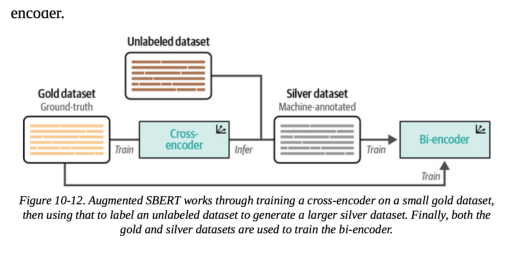

In [3]:
imggen('augsbert.png')

In [4]:
from tqdm import tqdm
import pandas as pd
from sentence_transformers.datasets import NoDuplicatesDataLoader
from datasets import load_dataset, Dataset
from sentence_transformers import InputExample
train_dataset=load_dataset('glue','mnli',split= 'train').select(range(50_000))
train_dataset.remove_columns('idx')
mapping={0:1,1:0,2:0}

gold_examples=[
    InputExample(texts=[row['premise'], row['hypothesis']],label=mapping[row["label"]])
    for row in tqdm(train_dataset)
]
gold_dataloader = NoDuplicatesDataLoader(gold_examples, batch_size=32)
gold=pd.DataFrame(
    {
    "sentence1": train_dataset['premise'],
    'sentence2': train_dataset['hypothesis'],
    'label': [mapping[label] for label in train_dataset['label']]
    }
)


/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 50000/50000 [00:00<00:00, 69787.29it/s]


In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

cross_encoder= CrossEncoder('bert-base-uncased',num_labels=2)
cross_encoder.fit(
    train_dataloader=gold_dataloader,
    show_progress_bar=True,
    epochs=1,
    use_amp=False,
    warmup_steps=100
)

In [5]:
silver= load_dataset("glue","mnli",split="train").select(range(10_000,50_000))
pairs=list(zip(silver['premise'],silver['hypothesis']))

In [6]:
# now we predict from these silver dset sentence pairs
output=cross_encoder.predict(
    pairs, show_progress_bar=True,
    apply_softmax=True
)
siler=pd.DataFrame(
    {
    'sentence1': silver['premise'],
    'sentence2': silver['hypothesis'],
    'label': np.argmax(output, axis=1)
    }
)

NameError: name 'cross_encoder' is not defined

In [7]:
final_dset= pd.concat([gold, silver], ignore_index=True, axis=1)
final_dset= final_dset.drop_duplicates(subset=['sentence1','sentence2'], keep='first')
train_dataset= Dataset.from_pandas(final_dset, preserve_index=False)

TypeError: cannot concatenate object of type '<class 'datasets.arrow_dataset.Dataset'>'; only Series and DataFrame objs are valid

In [3]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from datasets import load_dataset
val_sts= load_dataset('glue','stsb',split="validation")
evaluator= EmbeddingSimilarityEvaluator(
    sentences1= val_sts['sentence1'], 
    sentences2= val_sts['sentence2'],
    scores= [score/5 for score in val_sts['labels']],
    main_similarity='cosine'
)

ValueError: Column 'labels' doesn't exist.

In [ ]:
from sentence_transformers import losses, SentenceTransformer
import sentence_transformers
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

embedding_model=SentenceTransformer('bert-base-uncased')
loss= losses.CosineSimilarityLoss(model=embedding_model)

args = SentenceTransformerTrainingArguments(
output_dir="augmented_embedding_model",
num_train_epochs=1,
per_device_train_batch_size=32,
per_device_eval_batch_size=32,
warmup_steps=100,
eval_steps=100,
logging_steps=100,
)

# Train model
trainer = SentenceTransformerTrainer(
model=embedding_model,
args=args,
train_dataset=train_dataset,
loss=train_loss,
evaluator=evaluator
)
trainer.train()